In [12]:
!pip install seaborn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
import polars as pl

In [68]:
stories = pl.read_parquet("data/stories.parquet")
stories

id,type,by,time,title,text,url,score,parent,top_level_parent,descendants,kids,deleted,dead,top_comment
i64,str,str,datetime[μs],str,str,str,f64,f64,i64,f64,list[i64],bool,bool,str
1025241,"""story""","""peter123""",2010-01-01 00:07:39,"""Paul Buchheit:…",null,"""http://paulbuc…",78.0,null,1025241,23.0,"[1025937, 1025291, 1025383]",null,null,"""Currently ther…"
1025438,"""story""","""phsr""",2010-01-01 03:54:48,"""TSA Withdraws …",null,"""http://www.wir…",37.0,null,1025438,9.0,"[1025506, 1025494, … 1025972]",null,null,"""And if they ha…"
1025832,"""story""","""Flemlord""",2010-01-01 15:59:03,"""Apple Expects …",null,"""http://www.blo…",32.0,null,1025832,28.0,"[1025968, 1025919, … 1025964]",null,null,"""Snow Leopard (…"
1025975,"""story""","""samstokes""",2010-01-01 17:57:21,"""Maven builds a…",null,"""http://kent.sp…",42.0,null,1025975,50.0,"[1026093, 1026138, … 1026731]",null,null,"""I've had a go …"
1026018,"""story""","""russell""",2010-01-01 18:28:57,"""Ladies Home Jo…",null,"""http://www.yor…",48.0,null,1026018,30.0,"[1026466, 1026436, … 1026741]",null,null,"""Wow, what a gr…"
1026111,"""story""","""robg""",2010-01-01 19:31:18,"""How to Train t…",null,"""http://www.nyt…",47.0,null,1026111,11.0,"[1026776, 1026734, … 1026774]",null,null,"""I'm in my 50s.…"
1026221,"""story""","""prakash""",2010-01-01 20:56:38,"""The Roots of L…",null,"""http://www.pau…",47.0,null,1026221,9.0,"[1026579, 1027124, … 1026827]",null,null,"""One note of in…"
1026228,"""story""","""prakash""",2010-01-01 21:00:39,"""Beyond PageRan…",null,"""http://measuri…",91.0,null,1026228,14.0,"[1026934, 1026562, … 1026416]",null,null,"""It speaks well…"
1026615,"""story""","""tptacek""",2010-01-02 02:14:18,"""How Not To Pro…",null,"""http://groups.…",174.0,null,1026615,76.0,"[1026639, 1027404, … 1027105]",null,null,"""Wow. Pratt's …"


In [102]:
avg_chars = (
    stories["top_comment"].str.len_chars().mean()
    + stories["title"].str.len_chars().mean()
    + stories["url"].str.len_chars().mean()
)

# A token averages to 4-5 chars in English
avg_input_tokens = avg_chars * 0.2

# Add extra tokens for the task instructions
avg_input_tokens += 100

total_input_tokens = avg_input_tokens * len(stories)

# Simple task, assume 10 output tokens
total_output_tokens = 10 * len(stories)

input_token_price = 0.0015 / 1000
output_token_price = 0.002 / 1000

approx_cost = (
    total_input_tokens * input_token_price + total_output_tokens * output_token_price
)
approx_cost

126.19520590602065

In [84]:
stories

id,type,by,time,title,text,url,score,parent,top_level_parent,descendants,kids,deleted,dead,top_comment,ai_ml,crypto,remote_work,rust,prompt_tokens,completion_tokens,period
i64,str,str,datetime[μs],str,bool,str,f64,bool,i64,f64,list[i64],bool,bool,str,bool,bool,bool,bool,i64,i64,datetime[μs]
1025241,"""story""","""peter123""",2010-01-01 00:07:39,"""Paul Buchheit:…",null,"""http://paulbuc…",78.0,null,1025241,23.0,"[1025937, 1025291, 1025383]",null,null,"""Currently ther…",false,false,false,false,506,38,2010-01-01 00:00:00
1025438,"""story""","""phsr""",2010-01-01 03:54:48,"""TSA Withdraws …",null,"""http://www.wir…",37.0,null,1025438,9.0,"[1025506, 1025494, … 1025972]",null,null,"""And if they ha…",false,false,false,false,227,38,2010-01-01 00:00:00
1025832,"""story""","""Flemlord""",2010-01-01 15:59:03,"""Apple Expects …",null,"""http://www.blo…",32.0,null,1025832,28.0,"[1025968, 1025919, … 1025964]",null,null,"""Snow Leopard (…",false,false,false,false,181,38,2010-01-01 00:00:00
1025975,"""story""","""samstokes""",2010-01-01 17:57:21,"""Maven builds a…",null,"""http://kent.sp…",42.0,null,1025975,50.0,"[1026093, 1026138, … 1026731]",null,null,"""I've had a go …",false,false,false,false,558,38,2010-01-01 00:00:00
1026018,"""story""","""russell""",2010-01-01 18:28:57,"""Ladies Home Jo…",null,"""http://www.yor…",48.0,null,1026018,30.0,"[1026466, 1026436, … 1026741]",null,null,"""Wow, what a gr…",false,false,false,false,307,38,2010-01-01 00:00:00
1026111,"""story""","""robg""",2010-01-01 19:31:18,"""How to Train t…",null,"""http://www.nyt…",47.0,null,1026111,11.0,"[1026776, 1026734, … 1026774]",null,null,"""I'm in my 50s.…",false,false,false,false,347,38,2010-01-01 00:00:00
1026221,"""story""","""prakash""",2010-01-01 20:56:38,"""The Roots of L…",null,"""http://www.pau…",47.0,null,1026221,9.0,"[1026579, 1027124, … 1026827]",null,null,"""One note of in…",false,false,false,false,340,38,2010-01-01 00:00:00
1026228,"""story""","""prakash""",2010-01-01 21:00:39,"""Beyond PageRan…",null,"""http://measuri…",91.0,null,1026228,14.0,"[1026934, 1026562, … 1026416]",null,null,"""It speaks well…",true,false,false,false,166,38,2010-01-01 00:00:00
1026615,"""story""","""tptacek""",2010-01-02 02:14:18,"""How Not To Pro…",null,"""http://groups.…",174.0,null,1026615,76.0,"[1026639, 1027404, … 1027105]",null,null,"""Wow. Pratt's …",false,false,false,false,422,38,2010-01-01 00:00:00


In [71]:
stories = pl.read_parquet("data/stories-classified.parquet")

stories = stories.sort("time").with_columns(
    pl.col("time").dt.truncate("1q").alias("period")
)

counts = stories.group_by("period").count()
counts

period,count
datetime[μs],u32
2010-01-01 00:00:00,1198
2010-04-01 00:00:00,1415
2010-07-01 00:00:00,1550
2010-10-01 00:00:00,1881
2011-01-01 00:00:00,2145
2011-04-01 00:00:00,2025
2011-07-01 00:00:00,1961
2011-10-01 00:00:00,2147
2012-01-01 00:00:00,2308


In [83]:
stories.filter(pl.col("crypto"))[["id", "title"]].sample(n=10).to_dicts()

[{'id': 35649917, 'title': 'Dummy Boards: The Fun Figures of the 1600s'},
 {'id': 13739219, 'title': 'Multihash – self-describing hashes'},
 {'id': 8507482, 'title': 'Implementation of Apple Pay in-app payment crypto'},
 {'id': 35867682,
  'title': 'U.S. Crypto Exchange Bittrex Files for Bankruptcy'},
 {'id': 30127785,
  'title': 'Plagiarism as a patent amplifier: Understanding the delayed rollout of PQC'},
 {'id': 5513031, 'title': 'Bitcoin Is Fundamentally Flawed'},
 {'id': 33950085,
  'title': "Binance's Alleged Crypto Audit Failed, Not Even Its Auditor Would Vouch for It"},
 {'id': 18265948,
  'title': 'Alchemy: A Language and Compiler for Homomorphic Encryption Made Easy [pdf]'},
 {'id': 20502025,
  'title': 'Inside Coinbase’s Executive Turmoil: Conflicting Visions'},
 {'id': 27477022,
  'title': 'Ethereum community has solved a major problem of the Internet: Single Sign-On'}]

In [51]:
# tags = ["ai_ml", "crypto", "remote_work", "rust"]
tags = ["ai_ml", "crypto"]
tag_labels = {
    "ai_ml": "AI/ML",
    "crypto": "Blockchain",
    "remote_work": "Remote Work",
    "rust": "Rust",
}

joined = counts

for tag in tags:
    tag_counts = (
        stories.filter(pl.col(tag).eq(True))
        .group_by("period")
        .count()
        .rename({"count": tag})
    )
    joined = joined.join(tag_counts, on="period", how="outer")

joined = joined.sort("period").with_columns(
    [pl.col(tag) / pl.col("count") for tag in tags]
)
joined

period,count,ai_ml,crypto
datetime[μs],u32,f64,f64
2010-01-01 00:00:00,1198,0.01586,0.005843
2010-04-01 00:00:00,1415,0.019081,0.003534
2010-07-01 00:00:00,1550,0.018065,0.008387
2010-10-01 00:00:00,1881,0.015949,0.009569
2011-01-01 00:00:00,2145,0.018648,0.006061
2011-04-01 00:00:00,2025,0.020741,0.019259
2011-07-01 00:00:00,1961,0.019378,0.014788
2011-10-01 00:00:00,2147,0.02748,0.007918
2012-01-01 00:00:00,2308,0.020364,0.009099


In [53]:
df = (
    joined[["period", *tags]]
    .melt(id_vars=["period"])
    .with_columns(pl.col("variable").map_dict(tag_labels))
    .rename({"variable": "Topic", "value": "Fraction of All Posts", "period": "Date"})
)
df

Date,Topic,Fraction of All Posts
datetime[μs],str,f64
2010-01-01 00:00:00,"""AI/ML""",0.01586
2010-04-01 00:00:00,"""AI/ML""",0.019081
2010-07-01 00:00:00,"""AI/ML""",0.018065
2010-10-01 00:00:00,"""AI/ML""",0.015949
2011-01-01 00:00:00,"""AI/ML""",0.018648
2011-04-01 00:00:00,"""AI/ML""",0.020741
2011-07-01 00:00:00,"""AI/ML""",0.019378
2011-10-01 00:00:00,"""AI/ML""",0.02748
2012-01-01 00:00:00,"""AI/ML""",0.020364


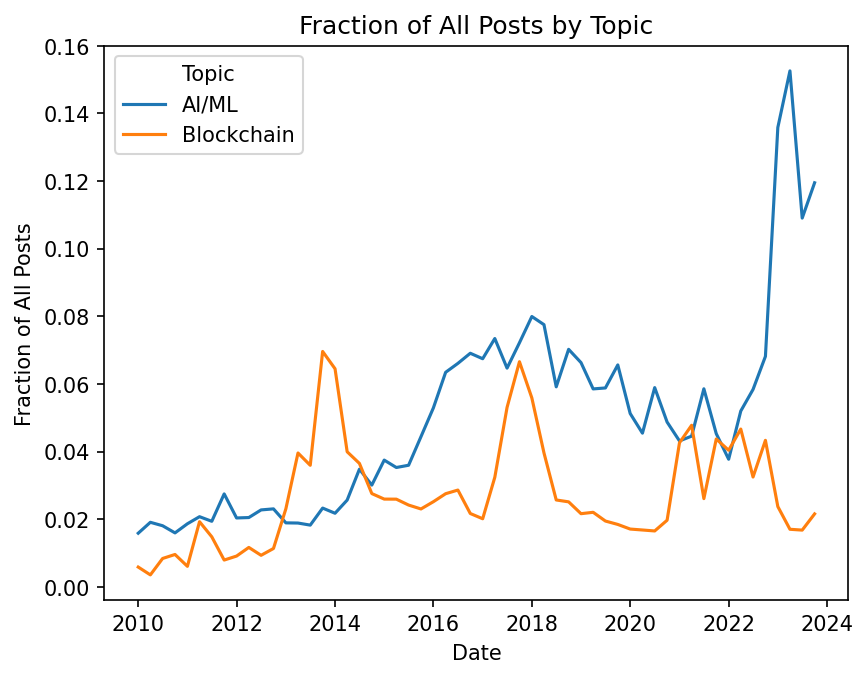

In [57]:
import seaborn as sns

plot = sns.lineplot(data=df, x="Date", y="Fraction of All Posts", hue="Topic")

plot.set_title("Fraction of All Posts by Topic")
plot.figure.set_dpi(150)

In [18]:
import json

sentiments = json.load(open("data/comment-sentiments.json"))

In [32]:
import pandas as pd

sentiments = pl.from_pandas(
    pd.read_json("data/comment-sentiments.json")
    .reset_index()
    .rename({"index": "id"}, axis=1)
)

In [33]:
comments = pl.read_parquet("data/hn.parquet", columns=["id", "time"])

comments = comments.join(sentiments, on="id", how="inner")

comments

id,time,ai_ml,rust,remote_work,crypto
i64,datetime[μs],str,str,str,str
1026300,2010-01-01 21:49:27,"""neutral""",null,null,null
1026331,2010-01-01 22:09:10,"""neutral""",null,null,null
1026389,2010-01-01 22:49:18,"""neutral""",null,null,null
1026416,2010-01-01 23:06:55,"""positive""",null,null,null
1026428,2010-01-01 23:15:02,"""positive""",null,null,null
1026543,2010-01-02 01:21:21,"""neutral""",null,null,null
1026562,2010-01-02 01:41:23,"""neutral""",null,null,null
1026733,2010-01-02 03:53:37,"""positive""",null,null,null
1026739,2010-01-02 03:58:53,"""negative""",null,null,null


In [109]:
crypto_ai_comments = comments.filter(
    pl.col("crypto").is_not_null() | pl.col("ai_ml").is_not_null()
)

# reported by OpenPipe
average_input_tokens = 446
average_output_tokens = 20

input_token_price = 0.03 / 1000
output_token_cost = 0.06 / 1000

total_cost = (
    input_token_price * average_input_tokens + output_token_cost * average_output_tokens
) * len(crypto_ai_comments)

total_cost

30425.22324

In [34]:
comments = comments.with_columns(pl.col("time").dt.truncate("1q").alias("period"))

comments

id,time,ai_ml,rust,remote_work,crypto,period
i64,datetime[μs],str,str,str,str,datetime[μs]
1026300,2010-01-01 21:49:27,"""neutral""",null,null,null,2010-01-01 00:00:00
1026331,2010-01-01 22:09:10,"""neutral""",null,null,null,2010-01-01 00:00:00
1026389,2010-01-01 22:49:18,"""neutral""",null,null,null,2010-01-01 00:00:00
1026416,2010-01-01 23:06:55,"""positive""",null,null,null,2010-01-01 00:00:00
1026428,2010-01-01 23:15:02,"""positive""",null,null,null,2010-01-01 00:00:00
1026543,2010-01-02 01:21:21,"""neutral""",null,null,null,2010-01-01 00:00:00
1026562,2010-01-02 01:41:23,"""neutral""",null,null,null,2010-01-01 00:00:00
1026733,2010-01-02 03:53:37,"""positive""",null,null,null,2010-01-01 00:00:00
1026739,2010-01-02 03:58:53,"""negative""",null,null,null,2010-01-01 00:00:00


In [35]:
comments.filter(pl.col("ai_ml").is_in(["positive", "negative"])).sort(
    "time"
).with_columns(
    pl.col("ai_ml")
    .map_dict({"positive": 1, "negative": 0})
    .rolling_mean("3mo_saturating", by="time"),
    pl.col("time").dt.truncate("1d").alias("period"),
).group_by(
    "period"
).mean()

/tmp/ipykernel_2518988/1733914315.py:4: DeprecationWarning: The default value for `closed` will change from 'left' to 'right' in a future version. Explicitly pass a value for `closed` to silence this warning.
  pl.col("ai_ml")


period,id,time,ai_ml,rust,remote_work,crypto
datetime[μs],f64,datetime[μs],f64,str,str,str
2010-01-01 00:00:00,1.026422e6,null,1.0,null,null,null
2010-01-02 00:00:00,1026785.5,null,0.8875,null,null,null
2010-01-15 00:00:00,1.055297e6,null,0.845238,null,null,null
2010-01-20 00:00:00,1.065676e6,null,0.875,null,null,null
2010-01-21 00:00:00,1.067467e6,null,0.888889,null,null,null
2010-01-22 00:00:00,1.0703e6,null,0.830186,null,null,null
2010-01-24 00:00:00,1.073599e6,null,0.785714,null,null,null
2010-01-25 00:00:00,1.074676e6,null,0.8,null,null,null
2010-01-28 00:00:00,1.083829e6,null,0.75,null,null,null


/tmp/ipykernel_2518988/1986017386.py:13: DeprecationWarning: The default value for `closed` will change from 'left' to 'right' in a future version. Explicitly pass a value for `closed` to silence this warning.
  pl.col(tag)


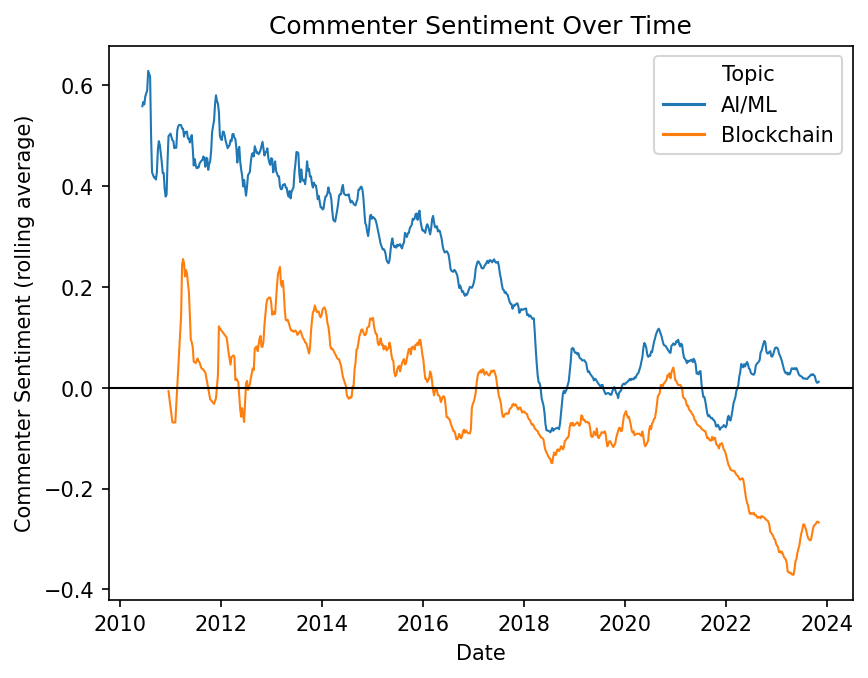

In [112]:
df = pl.DataFrame(schema={"period": pl.Datetime, "Topic": str, "value": pl.Float64})

for tag in ["ai_ml", "crypto"]:
    min_samples = 100
    relevant_comments = comments.filter(
        pl.col(tag).is_in(["positive", "negative"])
    ).sort("time")

    earliest_reporting_date = relevant_comments[min_samples]["time"]

    filtered = (
        relevant_comments.with_columns(
            pl.col(tag)
            .map_dict({"positive": 1, "negative": -1, "neutral": 0})
            .rolling_mean("6mo_saturating", by="time")
            .alias("value"),
            pl.col("time").dt.truncate("1w").alias("period"),
        )
        .group_by("period")
        .mean()
        .with_columns(pl.lit(tag_labels[tag]).alias("Topic"))
        .filter(pl.col("period") > earliest_reporting_date)
    )

    df = df.vstack(filtered[["period", "Topic", "value"]])


plot = sns.lineplot(
    data=df,
    x="period",
    y="value",
    hue="Topic",
)

# set the line width
for l in plot.lines:
    l.set_linewidth(1)

plot.set_xlabel("Date")
plot.set_ylabel("Commenter Sentiment (rolling average)")

plot.figure.set_dpi(150)

plot.set_title("Commenter Sentiment Over Time")

# Draw an axis line at y=0
plot.axhline(0, color="black", linewidth=1)

In [24]:
fracs_positive.melt(id_vars=["period"])

NameError: name 'fracs_positive' is not defined